In [65]:
from pathlib import Path
from operator import itemgetter
import copy

import gin
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from src.game import Game, CircleL1
from src.agents import Reinforce, Deterministic, Gaussian
from src.train import train

In [71]:
def plot(logdir, savedir=None, name='error', last_epochs=10, show=True, verbose=True):
    if savedir:
        savepath = Path(savedir)
        savepath.mkdir(exist_ok=True)
        
    logpath = Path(logdir)    

    config_file = next(logpath.glob('**/*.gin'))
    if verbose:
        print(f'config file {config_file}')
    gin.parse_config_file(config_file, skip_unknown=True)
    
    bias = gin.config.query_parameter('Game.bias')
    num_points = gin.config.query_parameter('Game.num_points')
    num_epochs = gin.config.query_parameter('train.num_epochs')
    vocab_size = gin.config.query_parameter('train.vocab_size')

#     test_loss = CircleL1(num_points)
    
    Sender = gin.config.query_parameter('train.Sender')
    if str(Sender) == '@Reinforce':
        sender = Reinforce(input_size=1,
                           output_size=vocab_size,
                           mode=0)
    elif str(Sender) == '@Gaussian':
        sender = Gaussian(input_size=1,
                          output_size=1,
                          mode=0)
    
    models = [] 
    for path in logpath.glob('**/*.save'):
        print(f'loading model from {path}')
        model_save = torch.load(path, map_location=torch.device('cpu'))
        sender_copy = copy.deepcopy(sender)
        sender_copy.load_state_dict(model_save['sender'])
        models.append(sender_copy)
    #         with open(path, 'r') as logfile:
    #             try:
    #                 new_log = pd.read_json(logfile)
    #             except:
    #                 print(f'JSON error in log at {path}')
    #             else:
    #                 run_logs.append(new_log)

    #     logs = pd.concat(run_logs, ignore_index=True)
    #     sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
    #     recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])


    test_game = Game(num_batches=1,
                    batch_size=100,
                    device='cpu',
                    training=False)

#     send_target, _ = next(iter(test_game))
    send_target = torch.tensor([0.])
    for sender_model in models:
        dist = sender_model.forward_dist(send_target)
        model_samples = dist.sample(sample_shape=(1000,)).flatten()
        print(f'sampled model with var {dist.variance.item()}')
        sns.distplot(model_samples, kde=False, rug=True)
        if show:
            plt.show()
            plt.clf()

# #         metric = "test_l1_error" if "test_l1_error" in sender else "test_error"
        
#         if 'error' in metric:
#             # Rewards
#             sns.lineplot(data=sender, x="epoch", y=sender[metric]*10, label="sender")
#             sns.lineplot(data=recver, x="epoch", y=recver[metric]*10, label="receiver")
#         else:
#             sns.lineplot(data=sender, x="epoch", y=sender[metric], label="sender")
#             sns.lineplot(data=recver, x="epoch", y=recver[metric], label="receiver")
            
#         # Baselines
#         nocomm_diff = torch.tensor(36 / 4)
#         nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
#         fair_error = test_loss(torch.tensor(0.), bias/2)*10
#         plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
#         plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))

#         plt.ylabel(r'Test $L_1$ loss')

#         if savedir:
#             plt.savefig(savepath / f'{name}.png',  bbox_inches='tight')
            
#         plt.show()
    


#     error_sum = pd.DataFrame(sender['test_l1_error'] + recver['test_l1_error']).join(logs['epoch'])
#     error_last = error_sum[error_sum['epoch'] >= num_epochs - last_epochs]
    
#     return [error_last[i*last_epochs:(i+1)*last_epochs]['test_l1_error'].mean() for i in range(5)] 

    
def plot_hyperparam_results(results_dir, label='', savepath=None, last_epochs=10, show=True):
    results_path = Path(results_dir)
    
    results = []
    for result_folder in results_path.iterdir():
        if not result_folder.is_dir():
            continue
        
        folder_name = result_folder.name
        
        if not 'bias' in folder_name:
            continue
        
        bias_index = folder_name.index('bias') + 4
        if int(folder_name[bias_index]) in [0,3,6,9]:
            bias = int(folder_name[bias_index])
        elif int(folder_name[bias_index]) == 1 and int(folder_name[bias_index+1]) in [2,5,8]:
            bias = int(folder_name[bias_index:bias_index+2])
        else:
            raise Exception(f'couldnt figure out bias of {folder_name}')
        
        results.append({
            'bias': bias,
            'name': f'{label}-bias{bias}',
            'path': result_folder,
        })
    
    df = pd.DataFrame()
    
    for bias_result in sorted(results, key=itemgetter('bias')):
        bias = bias_result['bias']
        folder_path = bias_result['path']
        name = bias_result['name']

        try:
            print(f'Bias {bias}')
            seed_scores = plot(folder_path, savepath, name, last_epochs=last_epochs, show=show, verbose=True)  
#             for score in seed_scores:
#                 df = df.append({**bias_result, 'seed_score':score}, ignore_index=True)
        except Exception as e:
            print(f'In {folder_path.name} error for bias {bias}')
            print(f'Exception {e}')   
    
#     if show:
#         plt.axhline(torch.tensor(360 / 2), label='no communication', color="black", dashes=(2,2,2,2))
        
#     sns.lineplot(data=df, x=df['bias']*10, y=df['seed_score']*10, label=label)
#     plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
#     plt.legend()
#     if savepath is not None:
#         savepath.mkdir(exist_ok=True)
#         plt.savefig(savepath / f'{results_path.name}-all.png',  bbox_inches='tight')
    
#     if show:
#         plt.show()
#         plt.clf()
    
#     return df

Bias 0
config file ../results/cat-deter-32768/cat-deter-32768-bias0_b6a9d5ea3490bf31c4e8ff6405b4f0ff/0/config.gin
loading model from ../results/cat-deter-32768/cat-deter-32768-bias0_b6a9d5ea3490bf31c4e8ff6405b4f0ff/0/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias0_b6a9d5ea3490bf31c4e8ff6405b4f0ff/1/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias0_b6a9d5ea3490bf31c4e8ff6405b4f0ff/2/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias0_b6a9d5ea3490bf31c4e8ff6405b4f0ff/3/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias0_b6a9d5ea3490bf31c4e8ff6405b4f0ff/4/models.save
sampled model


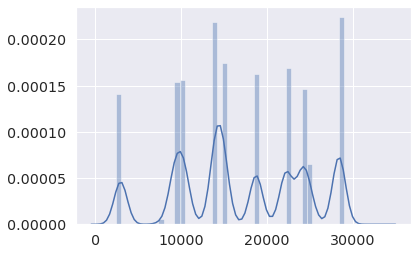

sampled model


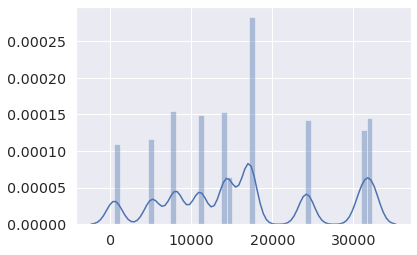

sampled model


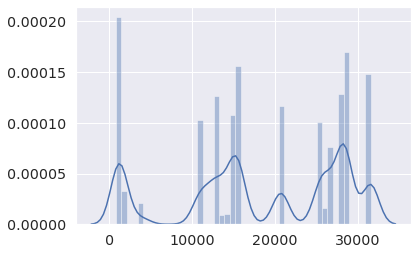

sampled model


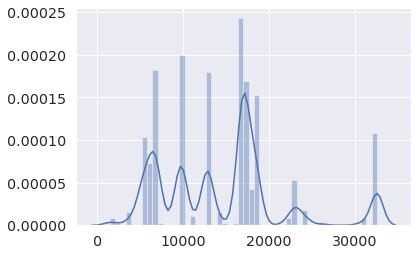

sampled model


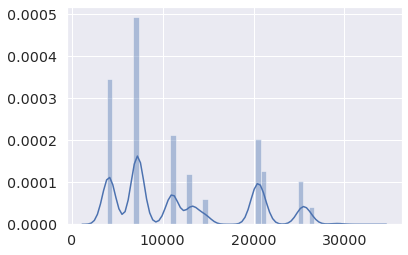

Bias 3
config file ../results/cat-deter-32768/cat-deter-32768-bias3_f0cdb116d0e1648fba1e55d963f91a0c/0/config.gin
loading model from ../results/cat-deter-32768/cat-deter-32768-bias3_f0cdb116d0e1648fba1e55d963f91a0c/0/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias3_f0cdb116d0e1648fba1e55d963f91a0c/1/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias3_f0cdb116d0e1648fba1e55d963f91a0c/2/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias3_f0cdb116d0e1648fba1e55d963f91a0c/3/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias3_f0cdb116d0e1648fba1e55d963f91a0c/4/models.save
sampled model


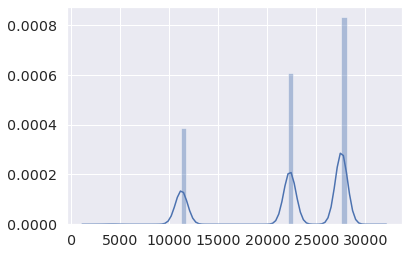

sampled model


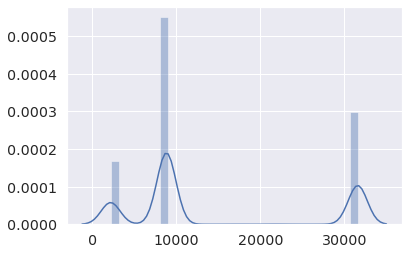

sampled model


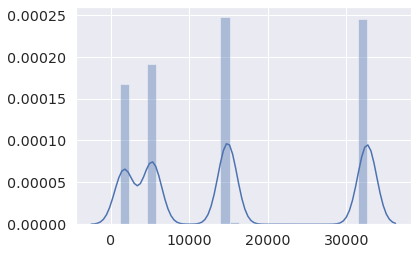

sampled model


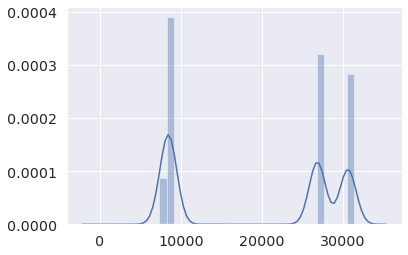

sampled model


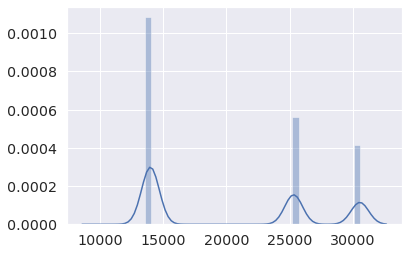

Bias 6
config file ../results/cat-deter-32768/cat-deter-32768-bias6_4906da4599eec0d8c0d4ecfa80c9e343/0/config.gin
loading model from ../results/cat-deter-32768/cat-deter-32768-bias6_4906da4599eec0d8c0d4ecfa80c9e343/0/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias6_4906da4599eec0d8c0d4ecfa80c9e343/1/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias6_4906da4599eec0d8c0d4ecfa80c9e343/2/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias6_4906da4599eec0d8c0d4ecfa80c9e343/3/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias6_4906da4599eec0d8c0d4ecfa80c9e343/4/models.save
sampled model


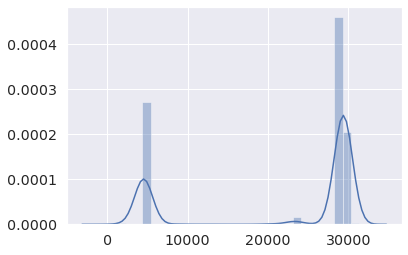

sampled model


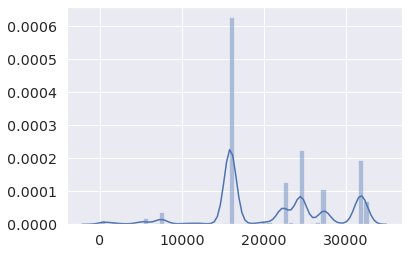

sampled model


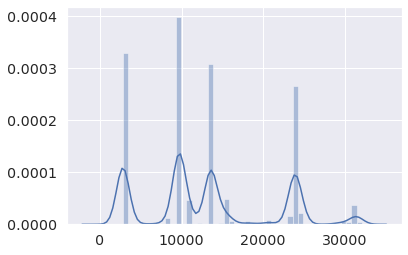

sampled model


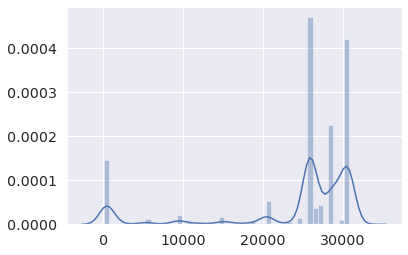

sampled model


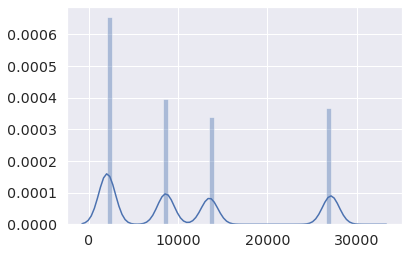

Bias 9
config file ../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/0/config.gin
loading model from ../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/0/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/1/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/2/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/3/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/4/models.save


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [60]:
result_path = Path('../results')

with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)

    plot_hyperparam_results(result_path / 'cat-deter-32768', 'Discrete Messages', result_path / 'plots')

Bias 0
config file ../results/cat-deter/cat-deter-bias0_ccdaaf9895ef5d3b799f0a6f4a6d1941/0/config.gin
loading model from ../results/cat-deter/cat-deter-bias0_ccdaaf9895ef5d3b799f0a6f4a6d1941/0/models.save
loading model from ../results/cat-deter/cat-deter-bias0_ccdaaf9895ef5d3b799f0a6f4a6d1941/1/models.save
loading model from ../results/cat-deter/cat-deter-bias0_ccdaaf9895ef5d3b799f0a6f4a6d1941/2/models.save
loading model from ../results/cat-deter/cat-deter-bias0_ccdaaf9895ef5d3b799f0a6f4a6d1941/3/models.save
loading model from ../results/cat-deter/cat-deter-bias0_ccdaaf9895ef5d3b799f0a6f4a6d1941/4/models.save
sampled model


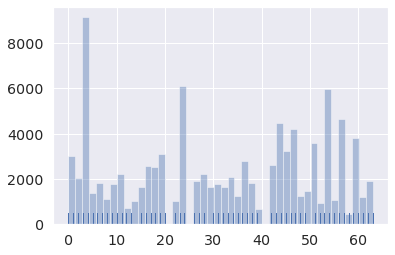

sampled model


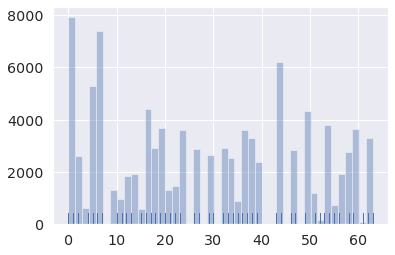

sampled model


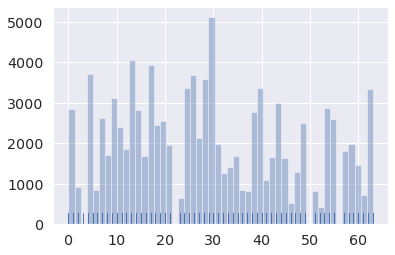

sampled model


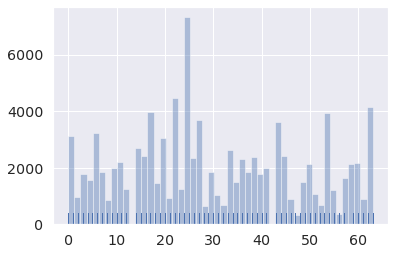

sampled model


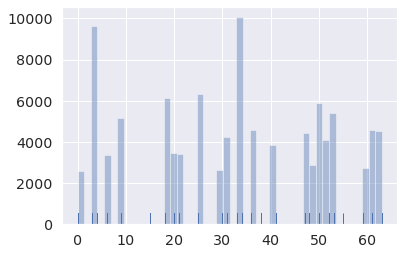

Bias 3
config file ../results/cat-deter/cat-deter-bias3_81899d894460237671f3a93a22874e24/0/config.gin
loading model from ../results/cat-deter/cat-deter-bias3_81899d894460237671f3a93a22874e24/0/models.save
loading model from ../results/cat-deter/cat-deter-bias3_81899d894460237671f3a93a22874e24/1/models.save
loading model from ../results/cat-deter/cat-deter-bias3_81899d894460237671f3a93a22874e24/2/models.save
loading model from ../results/cat-deter/cat-deter-bias3_81899d894460237671f3a93a22874e24/3/models.save
loading model from ../results/cat-deter/cat-deter-bias3_81899d894460237671f3a93a22874e24/4/models.save
sampled model


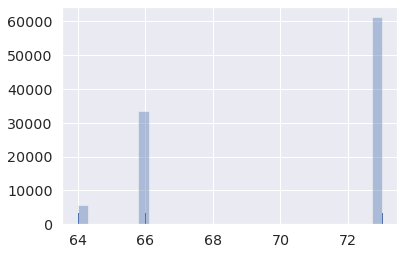

sampled model


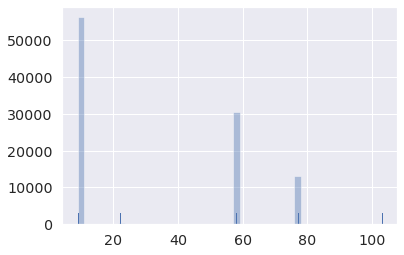

sampled model


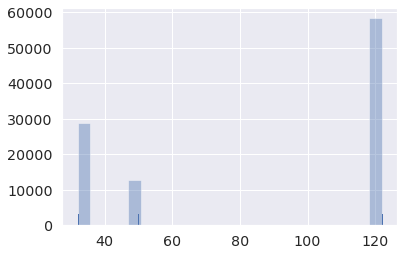

sampled model


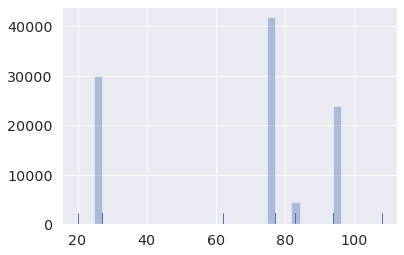

sampled model


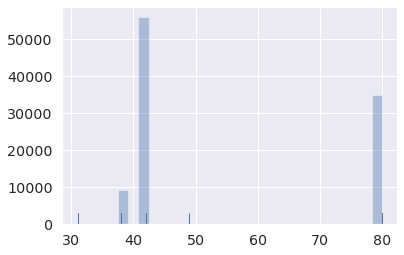

Bias 6
config file ../results/cat-deter/cat-deter-bias6_bf41a79c7e42823c59b22dc5a0bdc2d2/0/config.gin
loading model from ../results/cat-deter/cat-deter-bias6_bf41a79c7e42823c59b22dc5a0bdc2d2/0/models.save
loading model from ../results/cat-deter/cat-deter-bias6_bf41a79c7e42823c59b22dc5a0bdc2d2/1/models.save
loading model from ../results/cat-deter/cat-deter-bias6_bf41a79c7e42823c59b22dc5a0bdc2d2/2/models.save
loading model from ../results/cat-deter/cat-deter-bias6_bf41a79c7e42823c59b22dc5a0bdc2d2/3/models.save
loading model from ../results/cat-deter/cat-deter-bias6_bf41a79c7e42823c59b22dc5a0bdc2d2/4/models.save
sampled model


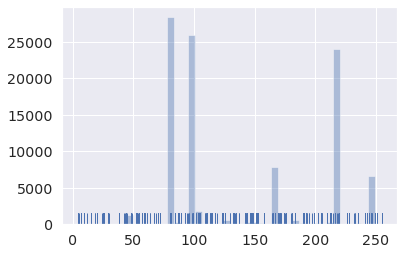

sampled model


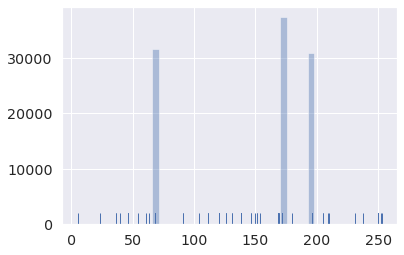

sampled model


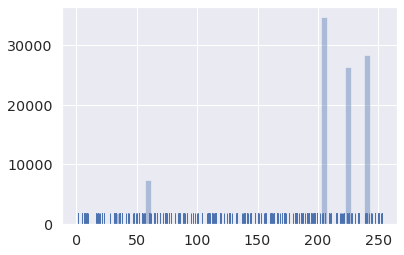

sampled model


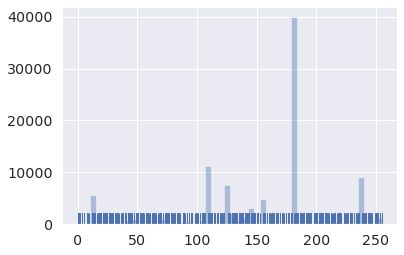

sampled model


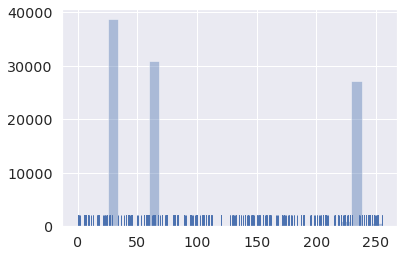

Bias 9
config file ../results/cat-deter/cat-deter-bias9_e6bd8f2fa333e106c66f57fd47111656/0/config.gin
loading model from ../results/cat-deter/cat-deter-bias9_e6bd8f2fa333e106c66f57fd47111656/0/models.save
loading model from ../results/cat-deter/cat-deter-bias9_e6bd8f2fa333e106c66f57fd47111656/1/models.save
loading model from ../results/cat-deter/cat-deter-bias9_e6bd8f2fa333e106c66f57fd47111656/2/models.save
loading model from ../results/cat-deter/cat-deter-bias9_e6bd8f2fa333e106c66f57fd47111656/3/models.save
loading model from ../results/cat-deter/cat-deter-bias9_e6bd8f2fa333e106c66f57fd47111656/4/models.save
sampled model


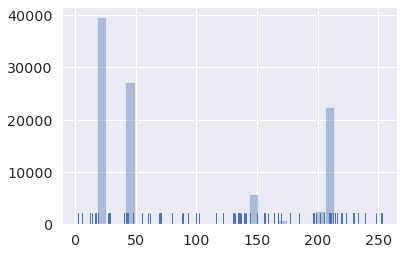

sampled model


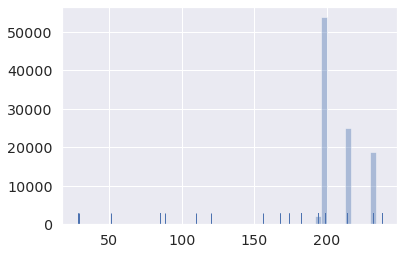

sampled model


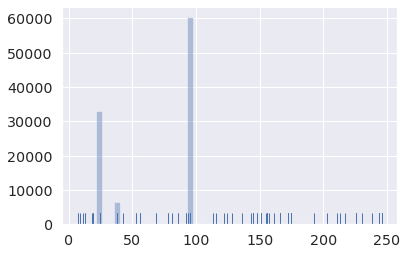

sampled model


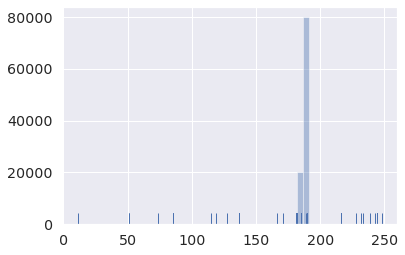

sampled model


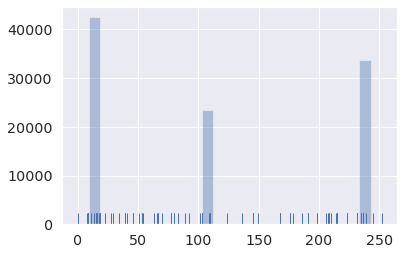

Bias 12
config file ../results/cat-deter/cat-deter-bias12_71fc21353506be635539d87b55b285fe/0/config.gin
loading model from ../results/cat-deter/cat-deter-bias12_71fc21353506be635539d87b55b285fe/0/models.save
loading model from ../results/cat-deter/cat-deter-bias12_71fc21353506be635539d87b55b285fe/1/models.save
loading model from ../results/cat-deter/cat-deter-bias12_71fc21353506be635539d87b55b285fe/2/models.save
loading model from ../results/cat-deter/cat-deter-bias12_71fc21353506be635539d87b55b285fe/3/models.save
loading model from ../results/cat-deter/cat-deter-bias12_71fc21353506be635539d87b55b285fe/4/models.save
sampled model


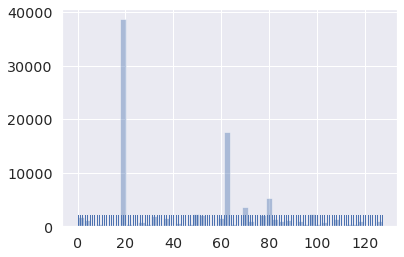

sampled model


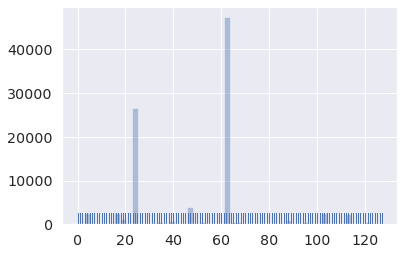

sampled model


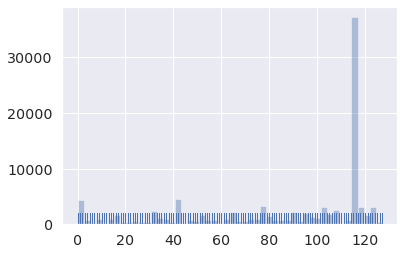

sampled model


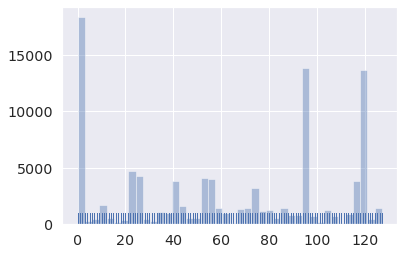

sampled model


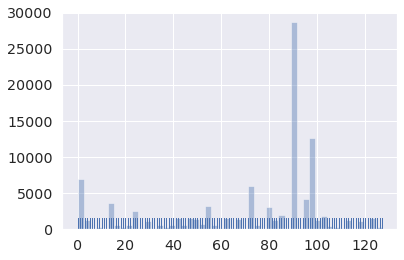

Bias 15
config file ../results/cat-deter/cat-deter-bias15_8aa72868f9c4f6eeb783c2bbd460c2b6/0/config.gin
loading model from ../results/cat-deter/cat-deter-bias15_8aa72868f9c4f6eeb783c2bbd460c2b6/0/models.save
loading model from ../results/cat-deter/cat-deter-bias15_8aa72868f9c4f6eeb783c2bbd460c2b6/1/models.save
loading model from ../results/cat-deter/cat-deter-bias15_8aa72868f9c4f6eeb783c2bbd460c2b6/2/models.save
loading model from ../results/cat-deter/cat-deter-bias15_8aa72868f9c4f6eeb783c2bbd460c2b6/3/models.save
loading model from ../results/cat-deter/cat-deter-bias15_8aa72868f9c4f6eeb783c2bbd460c2b6/4/models.save
sampled model


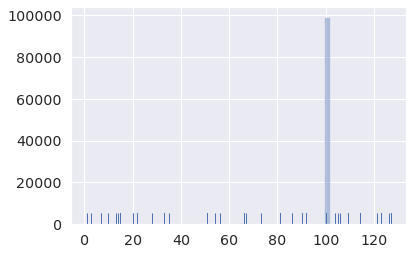

sampled model


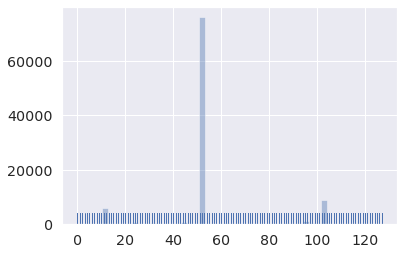

sampled model


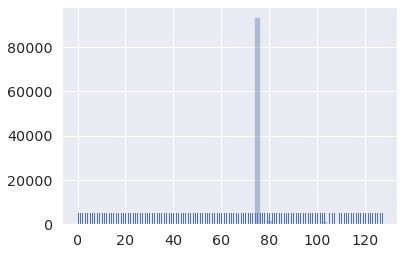

sampled model


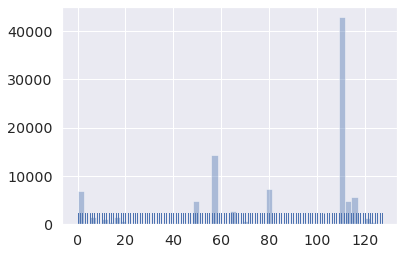

sampled model


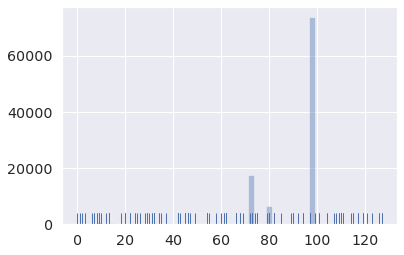

<Figure size 432x288 with 0 Axes>

In [63]:
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)

    plot_hyperparam_results(result_path / 'cat-deter', 'Discrete Messages', result_path / 'plots')

Bias 0
config file ../results/gauss-deter/gauss-deter-bias0_ae10554bd0d80af5d0931d0ed1f09c96/0/config.gin
loading model from ../results/gauss-deter/gauss-deter-bias0_ae10554bd0d80af5d0931d0ed1f09c96/0/models.save
loading model from ../results/gauss-deter/gauss-deter-bias0_ae10554bd0d80af5d0931d0ed1f09c96/1/models.save
loading model from ../results/gauss-deter/gauss-deter-bias0_ae10554bd0d80af5d0931d0ed1f09c96/2/models.save
loading model from ../results/gauss-deter/gauss-deter-bias0_ae10554bd0d80af5d0931d0ed1f09c96/3/models.save
loading model from ../results/gauss-deter/gauss-deter-bias0_ae10554bd0d80af5d0931d0ed1f09c96/4/models.save
sampled model with var 9.9999998245167e-15


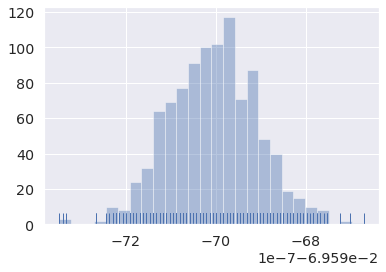

sampled model with var 9.9999998245167e-15


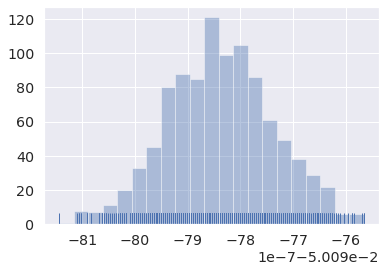

sampled model with var 9.9999998245167e-15


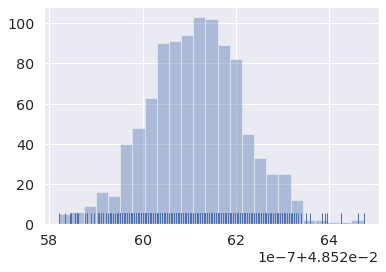

sampled model with var 9.9999998245167e-15


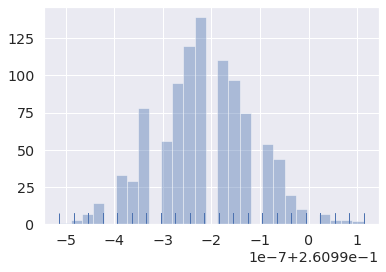

sampled model with var 9.9999998245167e-15


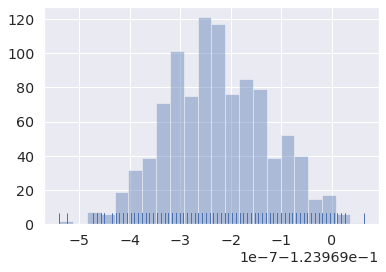

Bias 3
config file ../results/gauss-deter/gauss-deter-bias3_45ab321035dd1563482e0fe697379110/0/config.gin
loading model from ../results/gauss-deter/gauss-deter-bias3_45ab321035dd1563482e0fe697379110/0/models.save
loading model from ../results/gauss-deter/gauss-deter-bias3_45ab321035dd1563482e0fe697379110/1/models.save
loading model from ../results/gauss-deter/gauss-deter-bias3_45ab321035dd1563482e0fe697379110/2/models.save
loading model from ../results/gauss-deter/gauss-deter-bias3_45ab321035dd1563482e0fe697379110/3/models.save
loading model from ../results/gauss-deter/gauss-deter-bias3_45ab321035dd1563482e0fe697379110/4/models.save
sampled model with var 9.9999998245167e-15


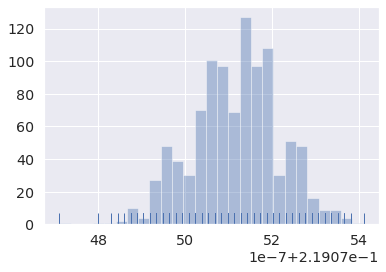

sampled model with var 9.9999998245167e-15


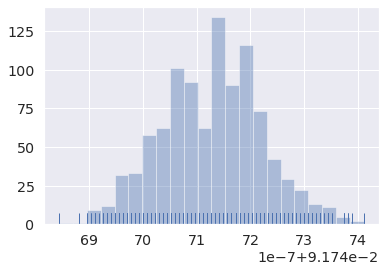

sampled model with var 9.9999998245167e-15


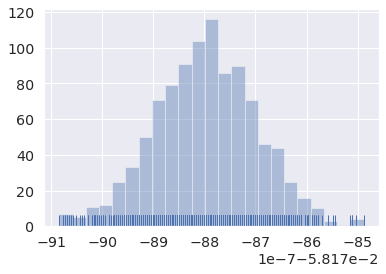

sampled model with var 9.9999998245167e-15


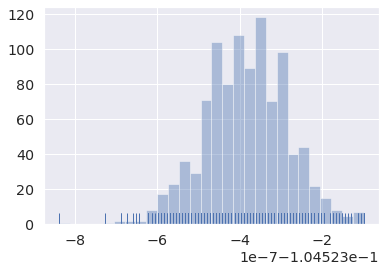

sampled model with var 9.9999998245167e-15


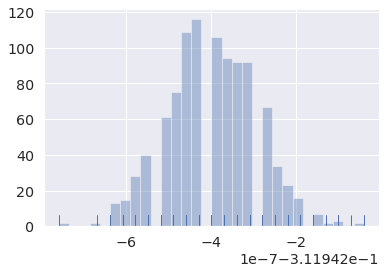

Bias 6
config file ../results/gauss-deter/gauss-deter-bias6_ba4b37f9a3d86129326d765a50818415/0/config.gin
loading model from ../results/gauss-deter/gauss-deter-bias6_ba4b37f9a3d86129326d765a50818415/0/models.save
loading model from ../results/gauss-deter/gauss-deter-bias6_ba4b37f9a3d86129326d765a50818415/1/models.save
loading model from ../results/gauss-deter/gauss-deter-bias6_ba4b37f9a3d86129326d765a50818415/2/models.save
loading model from ../results/gauss-deter/gauss-deter-bias6_ba4b37f9a3d86129326d765a50818415/3/models.save
loading model from ../results/gauss-deter/gauss-deter-bias6_ba4b37f9a3d86129326d765a50818415/4/models.save
sampled model with var 9.9999998245167e-15


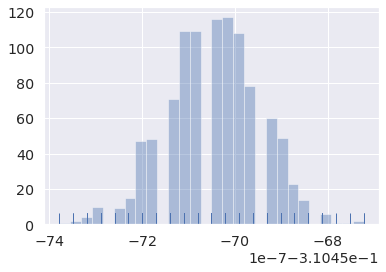

sampled model with var 9.9999998245167e-15


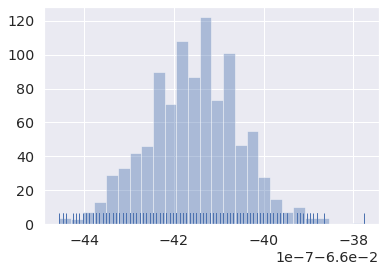

sampled model with var 9.9999998245167e-15


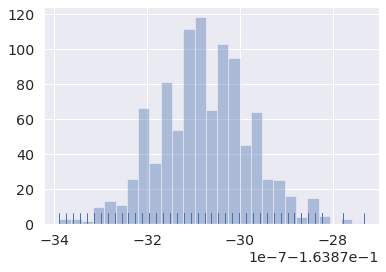

sampled model with var 9.9999998245167e-15


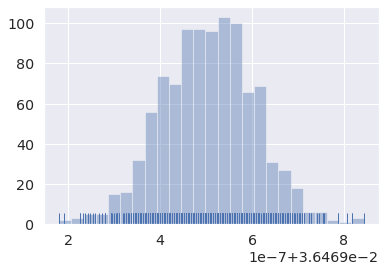

sampled model with var 9.9999998245167e-15


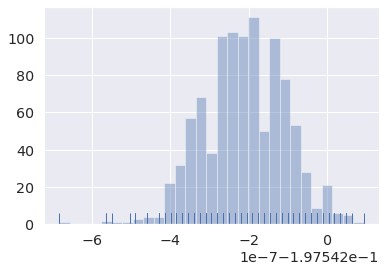

Bias 9
config file ../results/gauss-deter/gauss-deter-bias9_d746772b84faa531f1a2fae34b7bc296/0/config.gin
loading model from ../results/gauss-deter/gauss-deter-bias9_d746772b84faa531f1a2fae34b7bc296/0/models.save
loading model from ../results/gauss-deter/gauss-deter-bias9_d746772b84faa531f1a2fae34b7bc296/1/models.save
loading model from ../results/gauss-deter/gauss-deter-bias9_d746772b84faa531f1a2fae34b7bc296/2/models.save
loading model from ../results/gauss-deter/gauss-deter-bias9_d746772b84faa531f1a2fae34b7bc296/3/models.save
loading model from ../results/gauss-deter/gauss-deter-bias9_d746772b84faa531f1a2fae34b7bc296/4/models.save
sampled model with var 9.9999998245167e-15


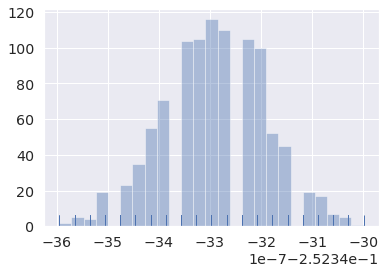

sampled model with var 9.9999998245167e-15


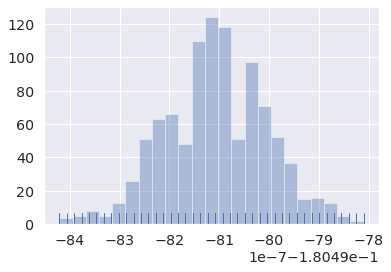

sampled model with var 9.9999998245167e-15


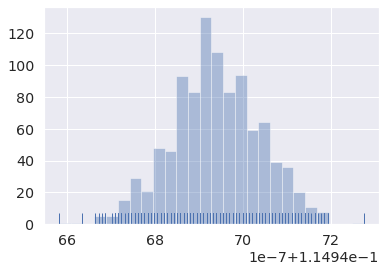

sampled model with var 9.9999998245167e-15


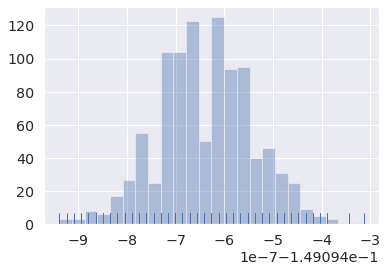

sampled model with var 9.9999998245167e-15


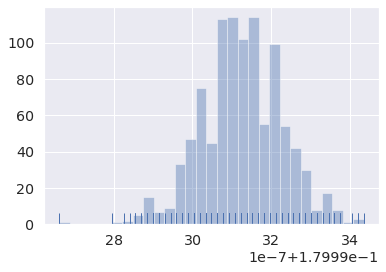

Bias 12
config file ../results/gauss-deter/gauss-deter-bias12_dd4d2d81417f60ef4924a3c374ba0303/0/config.gin
loading model from ../results/gauss-deter/gauss-deter-bias12_dd4d2d81417f60ef4924a3c374ba0303/0/models.save
loading model from ../results/gauss-deter/gauss-deter-bias12_dd4d2d81417f60ef4924a3c374ba0303/1/models.save
loading model from ../results/gauss-deter/gauss-deter-bias12_dd4d2d81417f60ef4924a3c374ba0303/2/models.save
loading model from ../results/gauss-deter/gauss-deter-bias12_dd4d2d81417f60ef4924a3c374ba0303/3/models.save
loading model from ../results/gauss-deter/gauss-deter-bias12_dd4d2d81417f60ef4924a3c374ba0303/4/models.save
sampled model with var 9.9999998245167e-15


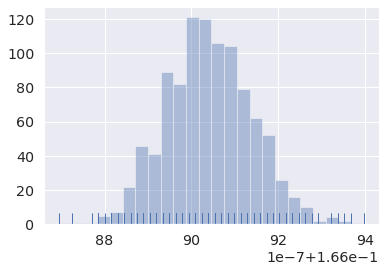

sampled model with var 9.9999998245167e-15


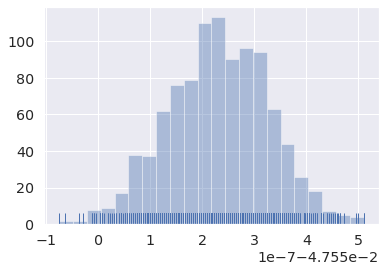

sampled model with var 9.9999998245167e-15


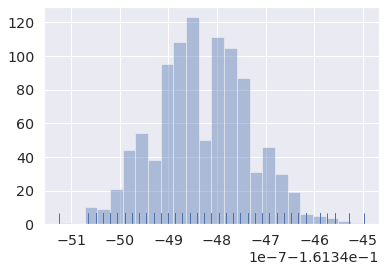

sampled model with var 9.9999998245167e-15


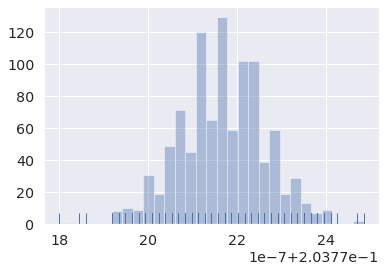

sampled model with var 9.9999998245167e-15


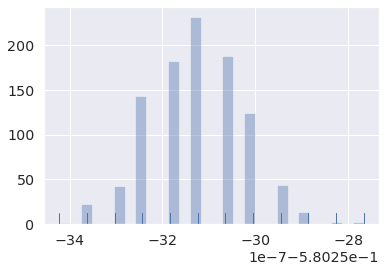

Bias 15
config file ../results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/0/config.gin
loading model from ../results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/0/models.save
loading model from ../results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/1/models.save
loading model from ../results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/2/models.save
loading model from ../results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/3/models.save
loading model from ../results/gauss-deter/gauss-deter-bias15_d0432824d4255c5133d3ca3d60c17ad9/4/models.save
sampled model with var 9.9999998245167e-15


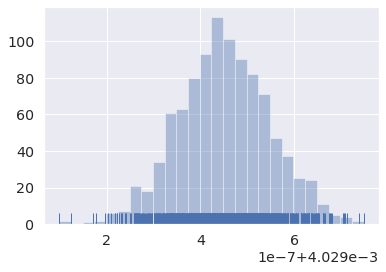

sampled model with var 653.939697265625


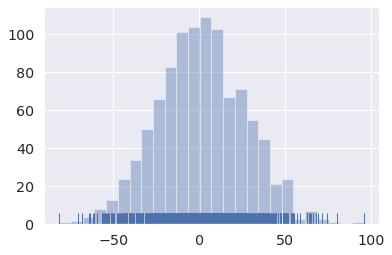

sampled model with var 9.9999998245167e-15


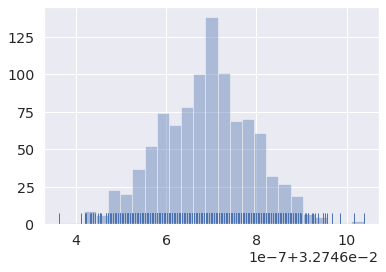

sampled model with var 9.9999998245167e-15


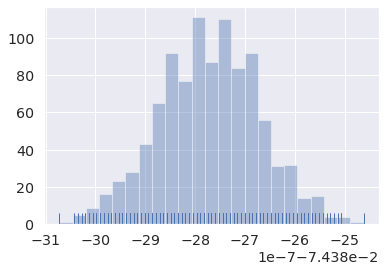

sampled model with var 9.9999998245167e-15


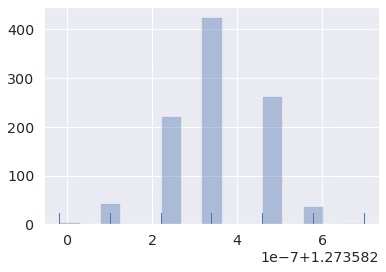

<Figure size 432x288 with 0 Axes>

In [72]:
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)

    plot_hyperparam_results(result_path / 'gauss-deter', 'Continuous Messages', result_path / 'plots')

loading model from ../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/0/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/1/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/2/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/3/models.save
loading model from ../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/4/models.save
sampled model


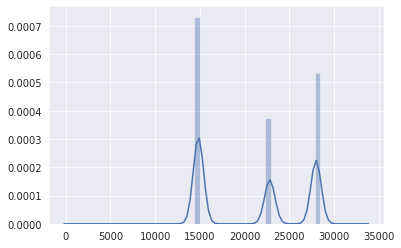

sampled model


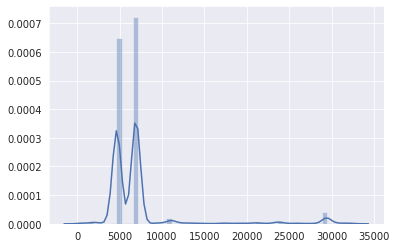

sampled model


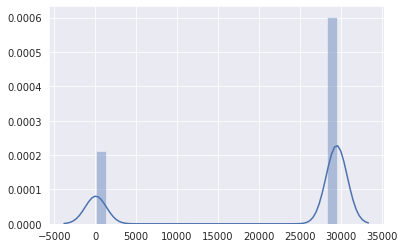

sampled model


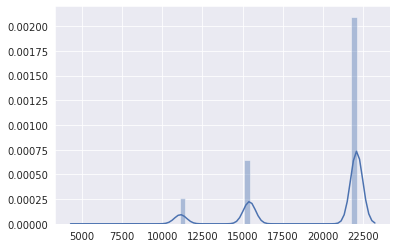

sampled model


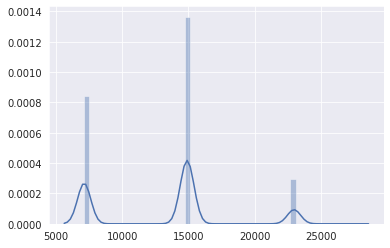

In [58]:
# logpath = Path('../results/cat-deter-32768/cat-deter-32768-bias9_07d3a07c10ebafa1932271839ef03720/')

# gin.parse_config_file(logpath / '0/config.gin', skip_unknown=True)

# bias = gin.config.query_parameter('Game.bias')
# num_points = gin.config.query_parameter('Game.num_points')
# Sender = gin.config.query_parameter('train.Sender')
# Recver = gin.config.query_parameter('train.Recver')
# vocab_size = gin.config.query_parameter('train.vocab_size')

# Sender = gin.config.query_parameter('train.Sender')
# if str(Sender) == '@Reinforce':
#     sender = Reinforce(input_size=1,
#                        output_size=vocab_size,
#                        mode=0)
# elif str(Sender) == '@Gaussian':
#     sender = Gaussian(input_size=1,
#                       output_size=1,
#                       mode=0)

# models = [] 
# for path in logpath.glob('**/*.save'):
#     print(f'loading model from {path}')
#     model_save = torch.load(path, map_location=torch.device('cpu'))
#     sender_copy = copy.deepcopy(sender)
#     sender_copy.load_state_dict(model_save['sender'])
#     models.append(sender_copy)
# #         with open(path, 'r') as logfile:
# #             try:
# #                 new_log = pd.read_json(logfile)
# #             except:
# #                 print(f'JSON error in log at {path}')
# #             else:
# #                 run_logs.append(new_log)

# #     logs = pd.concat(run_logs, ignore_index=True)
# #     sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
# #     recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])


# test_game = Game(num_batches=1,
#                 batch_size=100,
#                 device='cpu',
#                 training=False)

# send_target, _ = next(iter(test_game))
# for sender_model in models:
#     dist = sender_model.forward_dist(send_target)
#     model_samples = dist.sample(sample_shape=(1000,)).flatten()
#     print('sampled model')
#     sns.distplot(model_samples)
#     plt.show()

In [51]:
x = dist.sample(sample_shape=(100,))

In [53]:
x.flatten()

tensor([22972, 22972, 22972,  ..., 14808, 14808, 14808])

In [31]:
str(Sender) == '@Reinforce'

True